To load all dynamic text and charts...

0. Use a Python 3.5 Kernel.
1. Ensure all needed libraries are installed.

# Knewton Machine Learning Challenge - Will Nowak

*Intro: Before beginning, I would just like to reiterate my interest in, and my potential for the position. What follows are some of my investigations into a solution for this problem. They don’t rely heavily on an overly formal background in mathematics or test theory.* 

*I think that this makes my candidacy stronger. I am confident that I can assimilate the foundational concepts used at Knewton; I should think that Knewton seeks to find a data scientist who will think creatively, and contribute new ideas towards novel solutions. I think that my diverse background will allow me to do just this. I very much enjoyed this challenge and would relish the opportunity for further exploration. *


## Goal: "With the mid-term exam only a few days away, which questions should you exclude from the exam generation algorithm such that the exam results will provide the most meaningful ranking of the students in the class? Why?" 

Table of contents:
    
1. [Goals](#goals)
2. [Item Response Theory](#irt)
3. [Poor Questions](#pqs)
4. [Matching question difficulty to student ability](#mqd)
5. [Removed questions](#rqs)

To answer this question, we need to unpack "meaningful ranking." To simplify the question a bit, we will assume that we are attempting to order students along **one** singular dimension (in this case: Astrometrics proficiency (which is likely simplisticly assumed to be one-dimesional)).

Before I delve into my choice of questions to exclude, it is worth being explicit about the goals for our examination(s). 

### 1. Goals<a name="goals"></a>

1. Differentiation. (We would like to be able to distinguish between as many students as possible, instead of settling for "ties" in our ranking.)
2. Breadth. (We would like the ability to distinguish between students at all points on the one-dimensional spectrum of Astrometrics ability.)
2. Transitivity. (If student A possesses more ability than student B and student B > student C then our ranking will show student A > student C.)
2. Consistency of examination. (If student A and B were to swap tests, the new test would not lead to any change in rankings between student A and B.)

The set up is fairly unique in this case (we must choose at least 50% of the questions from the existing bank, and each student gets a random and uniform selection of 5 questions). So these constraints will limit us, but let's see if we cannot make some progress towards acheiving the aims above. 

### 2. Item Response Theory<a name="irt"></a>

Let's just go straight to the horse's mouth for help -- the [Knewton Tech Blog.](https://tech.knewton.com/blog/2012/06/understanding-student-performance-with-item-response-theory/ 
) Here, the authors discuss item response theory, and two important question parameters: difficulty and differentiation. Let's dig into the data and see if we can create this sort of model, based on the data from last year.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from scipy.optimize import curve_fit
%matplotlib inline  

In [2]:
# set seed
np.random.seed(1234)

In [3]:
# read data
df = pd.read_csv('astudentData.csv')

In [4]:
student_scores = df.groupby('user_id')['correct'].mean()# look at mean score for each student

The histogram<a name="studs"></a> below shows that the student score distribution was fairly normal, centered roughly around the median ({{print("%.2f" % student_scores.median())}}).

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


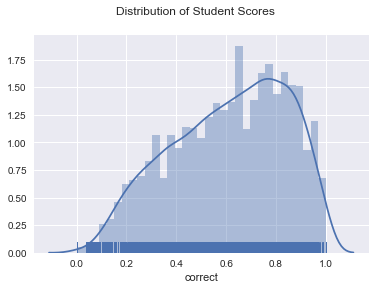

In [5]:
# Histogram of student scores
sns.distplot(student_scores, rug = True)
sns.plt.suptitle('Distribution of Student Scores')
plt.show()

In [6]:
# Tack on student score as a new column to original dataframe. 

# Again, find student scores. Create this as a pd dataframe. 
stu_scores = df.groupby('user_id')['correct'].mean().reset_index(name='student_score')
stu_scores_new_index = stu_scores.set_index(stu_scores['user_id'])
# rRset index to user_id
df_new_index = df.set_index(df['user_id'])
# Now merge to original df on user_id index
merged = df_new_index.merge(stu_scores_new_index)
merged.head()

,question_id,user_id,correct,student_score
0,13,63994,0,0.304
1,27,63994,0,0.304
2,57,63994,1,0.304
3,58,63994,0,0.304
4,59,63994,0,0.304


Above, we find the test score for each student on last year's test and tack it on to the given dataframe. 

In item response theory, the oft-described "two parameter" model uses - you guessed it - 2 parameters (often parameterized as difficulty ($\beta$) and differentiation ($\alpha$)) to model the probability of correct response ($p(x_i)$), given some level of student ability ($\theta$).

$p_i(x_j = 1 |  \theta, \alpha_j, \beta_j) = \frac{1}{1+ e^{-\alpha_j(\theta - \beta_j)}}$

In [7]:
def icc(x, a, b):
    '''
    define 2 parameter item characteristic model
    '''
    return 1/(1 + np.exp(a * (x - b)))

Item response theory assumes "local independence". In this case, we've no reason (since the previous teacher used our proposed algorithm of randomly selecting questions) to believe that this assumption does not hold. 

[Rasch.org](https://www.rasch.org/rmt/rmt213b.htm) explains: "That is, a correct or wrong reply to one item should not lead to a correct or wrong reply to another item." Since the questions are random, this should hold. 

In [8]:
# For loop to find alpha, beta for each question
ques_ids = merged.groupby('question_id').count() #.reset_index(name = 'ques_id')
alpha = []
beta = []
for i in ques_ids.index:
    q = merged.loc[merged['question_id'] == i]
    theta = q['student_score']
    p = q['correct']
    try:
        popt = curve_fit(icc, theta, p, p0 = (-5,.5)) # set parameters guess as -5, .5
        alpha.append(popt[0][0])
        beta.append(popt[0][1])
        print('fit {0} done'.format(i))
    except RuntimeError:
        alpha.append(0)
        beta.append(0)
        print('Question {0} took too long...skip.'.format(i))

# make parameter dataframe
d = {'alpha': alpha, 'beta': beta, 'question index': ques_ids.index}
param_df = pd.DataFrame(data=d)
param_df.sort_values('alpha')

fit 13 done
fit 21 done
fit 26 done
fit 27 done
fit 28 done
fit 37 done
fit 44 done
fit 45 done
fit 53 done
fit 54 done
fit 56 done
fit 57 done
fit 58 done
fit 59 done
fit 63 done
fit 64 done
fit 65 done
fit 66 done
fit 92 done
fit 102 done
fit 114 done
fit 130 done
fit 135 done
fit 141 done
fit 155 done
fit 159 done
fit 165 done
fit 166 done
fit 167 done
fit 169 done
fit 172 done
fit 176 done
fit 182 done
fit 186 done
fit 190 done
fit 191 done
fit 192 done
fit 194 done
fit 206 done
fit 223 done
fit 226 done
fit 230 done
fit 242 done
fit 243 done
fit 246 done
fit 251 done
fit 255 done
fit 268 done
fit 276 done
fit 302 done
fit 310 done
fit 311 done
fit 315 done
fit 335 done
fit 337 done
fit 345 done
fit 349 done
fit 360 done
fit 367 done
fit 369 done
fit 371 done
fit 375 done
fit 383 done
fit 388 done
fit 396 done
fit 397 done
fit 436 done
fit 438 done
fit 441 done
fit 445 done
fit 452 done
fit 456 done
fit 461 done
fit 470 done
fit 471 done
fit 504 done
fit 515 done
fit 527 done
fit 5

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


fit 12709 done
fit 12710 done
fit 12711 done
fit 12716 done
fit 12717 done
fit 12718 done
fit 12719 done
fit 12720 done
fit 12721 done
fit 12729 done
fit 12730 done
fit 12734 done
fit 12745 done
fit 12749 done
fit 12750 done
fit 12752 done
fit 12754 done
fit 12755 done
fit 12763 done
fit 12776 done
fit 12777 done
fit 12783 done
fit 12790 done
fit 12793 done
fit 12797 done
fit 12799 done
fit 12801 done
fit 12803 done
fit 12810 done
fit 12812 done
fit 12814 done
fit 12817 done
fit 12821 done
fit 12929 done
fit 12930 done
fit 12932 done
fit 12949 done
fit 13074 done
fit 13078 done
fit 13080 done
fit 13201 done
fit 13205 done
fit 13207 done
fit 13208 done
fit 13210 done
fit 13211 done
fit 13212 done
fit 13214 done
fit 13215 done
fit 13217 done
fit 13221 done
fit 13222 done
fit 13224 done
fit 13228 done
fit 13229 done
fit 13230 done
fit 13231 done
fit 13234 done
fit 13235 done
fit 13236 done
fit 13239 done
fit 13241 done
fit 13243 done
fit 13273 done
fit 13274 done
fit 13275 done
fit 13276 

,alpha,beta,question index
272,-1693.229558,0.668565,12209
47,-348.457038,0.138798,268
305,-221.043794,0.778917,12803
357,-185.608973,0.652467,13517
386,-17.232138,0.937226,15412
116,-15.068794,0.161987,694
112,-14.881589,0.267503,687
177,-14.543908,0.189634,1591
228,-13.143754,0.173091,4539
147,-12.096882,0.217997,1001


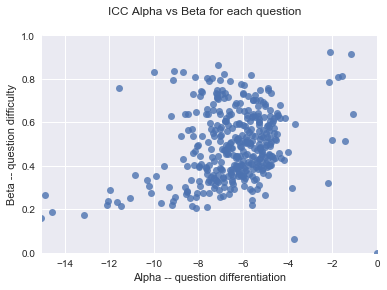

In [9]:
# Plot of alpha and beta for all of last year's questions
sns.regplot(param_df['alpha'], param_df['beta'], fit_reg=False)
plt.xlim(-15, 0)
plt.ylim(0,1)
sns.plt.xlabel('Alpha -- question differentiation')
sns.plt.ylabel('Beta -- question difficulty')
sns.plt.suptitle('ICC Alpha vs Beta for each question')
plt.show()

The plot above shows all of the questions from last year's test. This plot shows most of our points, but some outliers aren't see here.

Let's pick a random question and investigate it more thoroughly to get a better sense of what is going on here.

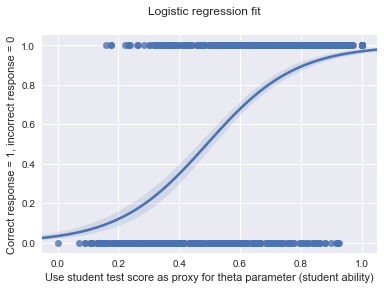

In [10]:
a_question = merged.loc[merged['question_id'] == 13]
x = a_question['student_score']
y= a_question['correct']
sns.regplot(x=x,y=y,data=a_question,logistic=True)
sns.plt.suptitle('Logistic regression fit')
sns.plt.xlabel('Use student test score as proxy for theta parameter (student ability)')
sns.plt.ylabel('Correct response = 1, incorrect response = 0')

plt.show()

The chart above shows that this question doesn't have a high degree of differentiation...lot's of students with high ability got it wrong and lots of students with low ability got it right. We can see that the "slope" of the steep part of the curve just isn't that steep, and so it isn't doing a great job in assessing the students' understanding of Astrometrics. 

Recall, the item characteristic model assumes that student ability is one dimensional. Unrealistic though this may be, we're sticking with it for now. If this is the case, and we are expected to sort students on this one dimension, a question like this isn't great. 

### 3. Poor Questions <a name="pqs"></a>

Before we select poor questions to exclude, let's get a better sense of some particular questions to feel more confident in our selection procedure. What are the questions we really want to avoid?

Below, we look at questions with positive alpha. This is not a good thing.

In [11]:
param_df.query('alpha>0')

,alpha,beta,question index
176,7.124500,0.444330,1232
279,225.817477,0.779424,12710
281,1.945250,0.569340,12716
282,2.753155,0.172438,12717


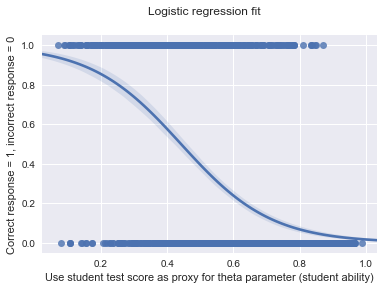

In [12]:
# let's look at the first question on the list above
bad_q = list(param_df.query('alpha>0')['question index'])[0]
bad_question1 = merged.loc[merged['question_id'] == bad_q]
x = bad_question1['student_score']
y= bad_question1['correct']
sns.regplot(x=x,y=y,data=bad_question1,logistic=True)
sns.plt.suptitle('Logistic regression fit')
sns.plt.xlabel('Use student test score as proxy for theta parameter (student ability)')
sns.plt.ylabel('Correct response = 1, incorrect response = 0')

plt.show()

Ya...this is not good. It seems like students with lower ability do **better** on this question. We are doing to operate under the assumption that correct responses relates to increased ability. This question flies in the face of that. Ideally, we want to only have negative alpha questions.

OK, so what about beta greater than 1 or less than 0? If we are assuming that test score = student ability = theta, then a question with beta outside of this 0-1 range will imply that this question is aced by everyone, or impossible. Neither are the sign of a good question if we are trying to rank the test takers. Remember, we want our questions to allow us to differentiate, and if there is no variation amongst the students, we can't do that.

In [13]:
param_df.query('beta>1')

,alpha,beta,question index
248,-2.249208,1.177172,5566
284,-2.544085,1.445717,12719
288,-2.038102,1.160517,12730
291,-1.757753,1.181655,12749
295,-4.509932,1.090120,12755


The plot below shows a simple linear regression for this question...essentially, it is so hard that no one (using a two-parameter ICC model) is predicted to be able to answer it correctly. This is not what we want, so we'll remove from this year's test.

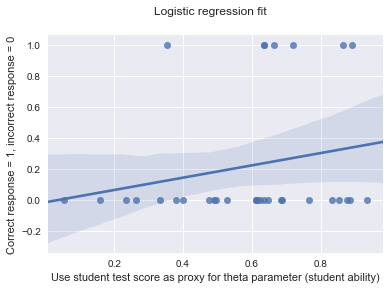

In [14]:
# a beta above 1
bad_q = list(param_df.query('beta>1')['question index'])[0]
bad_question1 = merged.loc[merged['question_id'] == bad_q]
x = bad_question1['student_score']
y= bad_question1['correct']
sns.regplot(x=x,y=y,data=bad_question1) #, logistic=True)
sns.plt.suptitle('Logistic regression fit')
sns.plt.xlabel('Use student test score as proxy for theta parameter (student ability)')
sns.plt.ylabel('Correct response = 1, incorrect response = 0')

plt.show()

The following questions have beta < 0, and we can see the plot. These questions are too easy.

In [15]:
param_df.query('beta<0')

,alpha,beta,question index
165,-0.845957,-0.793392,1113
275,-2.066647,-10.470703,12665


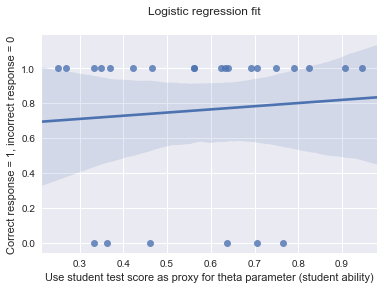

In [16]:
# a beta above 1
bad_q = list(param_df.query('beta<0')['question index'])[0]
bad_question1 = merged.loc[merged['question_id'] == bad_q]
x = bad_question1['student_score']
y= bad_question1['correct']
sns.regplot(x=x,y=y,data=bad_question1) #,logistic=True)
sns.plt.suptitle('Logistic regression fit')
sns.plt.xlabel('Use student test score as proxy for theta parameter (student ability)')
sns.plt.ylabel('Correct response = 1, incorrect response = 0')

plt.show()

Also, let's check if there are any questions that no one or everyone got right.

In [17]:
scores = df.groupby('question_id')['correct'].mean() 

In [18]:
sum(scores==0)

0

In [19]:
sum(scores==1)

1

In [20]:
scores[scores==1].reset_index()

,question_id,correct
0,12665,1.0


Question {{scores[scores==1].reset_index()['question_id'][0]}} is a problem child, as everyone got it right. If offers no explanatory power (or at least it didn't last time around), so we'll take that out too.

To recap...using item response theory as a guide, I propose to remove question based on the following criteria:

* no differentiation power ($\alpha > 0$)
* inappropriate difficulty ($\beta<0$ or $\beta>1$)
* 100% pass rate on last year's test

So far, we want to remove the following questions:

- 1113
- 1232 (doubly so...see 'inconsistent_qs.ipynb' for further explanation of this question's removal)
- 5566
- 12665
- 12710
- 12716
- 12717
- 12719
- 12730
- 12749	
- 12755

BUT...We might have some redundancy in the current test, so maybe we should remove a few more questions. That is, there are likely questions that have similar difficulty but different differentiation. In this case, we'd rather just keep the questions with higher differentiation. Let's see how a simple fix will do here.

Below, I will subset the questions from last year, including only those with beta between 0 and 1, and setting our standard for alpha at -6. (This standard was arbitrarily chosen, as it gives a number of questions that is high enough.)

In [21]:
final = param_df.query('alpha<-6 & beta>0 and beta<1')
final.shape

(216, 3)

We now have {{final.shape[0]}} questions. This is slightly above the 50% threshold our boss dictated, so that is nice.

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


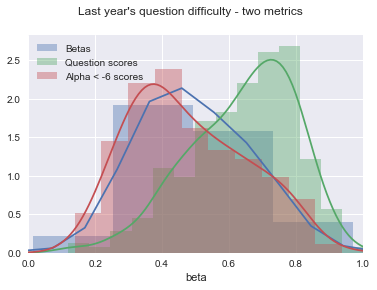

In [22]:
sns.distplot(param_df['beta'],label = 'Betas')
sns.distplot(scores, label = 'Question scores')
sns.distplot(final['beta'], label = 'Alpha < -6 scores')

plt.xlim(0,1)
sns.plt.suptitle('Last year\'s question difficulty - two metrics')
legend = plt.legend()

plt.show()

The plot above shows student scores, all of last year's questions' betas, and finally, the distribution of betas for just the highest alpha questions (|alpha| > 6).

So, though our method so far seems fairly reasonable, this plot above is bothering me. The red is far to the left of the green. Our questions are too easy! 

We are asking high alpha questions, which is sweet, but the average beta of the questions we are choosing is low. If the average student ability (as measured by score in last year's test) is near 60%, but the median of the question difficulty from the above subset (red) is {{print("%.3f" % final['beta'].median())}}, then we are asking questions that are too easy. 

We want to change this so we are still asking  questions with high differentiation, but do so in a way that our question difficulty better matches the student population. This should make sense -- if the kids are good, we want to ask more hard questions. If they are weak, easier questions. It should be intuitive that we want the question difficulty to match the likely distribution of student ability. Let's try to do it.

### 4. Matching question difficulty to student ability<a name="mqd"></a>

Let's split up our student scores into 100 bins. (We could reset this to another number, if we liked.) How many kids fall into certain ranges?

In [23]:
binned_scores = student_scores.value_counts(bins=100)
binned_scores = binned_scores.reset_index()
binned_scores = binned_scores.sort_values(by='index')
binned_scores[0:5] # this shows that 20 student had scores between 0 and .1

,index,correct
87,-0.001,20
99,0.010,0
98,0.020,0
95,0.030,4
93,0.040,9


In [24]:
binned_scores['percent_qs'] = binned_scores['correct']/len(student_scores)
binned_scores[0:5] # we add the perecent column. we want to know
                   # the relative frequency of scores

,index,correct,percent_qs
87,-0.001,20,0.001558
99,0.010,0,0.000000
98,0.020,0,0.000000
95,0.030,4,0.000312
93,0.040,9,0.000701


We see above that, of all the student scores, a small percent of them were between 0 and 1%. That's good news for the students and the old Astrometrics teacher!

In [25]:
total_num_qs = 300 # very roughly. this wont be exact, in the end
binned_scores['# questions to ask'] = binned_scores['percent_qs']*total_num_qs
binned_scores[0:5]

,index,correct,percent_qs,# questions to ask
87,-0.001,20,0.001558,0.467326
99,0.010,0,0.000000,0.000000
98,0.020,0,0.000000,0.000000
95,0.030,4,0.000312,0.093465
93,0.040,9,0.000701,0.210297


Decimals aren't helpful (we can't include a fraction of a question in our bank). So let's round this column.

In [26]:
binned_scores['rounded'] = binned_scores['# questions to ask'].round()
binned_scores[0:5]

,index,correct,percent_qs,# questions to ask,rounded
87,-0.001,20,0.001558,0.467326,0.0
99,0.010,0,0.000000,0.000000,0.0
98,0.020,0,0.000000,0.000000,0.0
95,0.030,4,0.000312,0.093465,0.0
93,0.040,9,0.000701,0.210297,0.0


Cool! 

The above is saying that we want to look at all of our questions and their difficulty. For each bin, we want to take the value in rounded number of questions to put in our bank.

Now, let's do some heavy lifting. We use pandas query to group the parameter dataframe so that we are just looking at a subset of questions in a certain range.

Then, we reference the rounded column and determine how many of the questions in this bin we should choose. We sort the questions on alpha score, and choose the questions with the lowest alpha (differentiability). 

In [27]:
examids=[]
param_df.sort_values(by='beta')
for i in range(len(binned_scores)): # for each bin
    look_here = param_df.query('beta>(@i/100) &beta<((@i+1)/100)') # look 
    # at params with beta between i/100 (eg 0) and i+1 / 100 (eg .01)
    num_to_take = binned_scores['rounded'].iloc[i] # look in binned_score df. 
    num_to_take = int(num_to_take)
    # how many questions in this range do we wanna take?
    sorted_look = look_here.sort_values(by='alpha',ascending=True)
    try:
        take = sorted_look['question index'].head(num_to_take)
        take_list = list(take.reset_index()['question index'])
        examids.append(take_list)
    except:
        pass

Just a little bit of cleaning to make our question id list prettier. 

In [28]:
# examids
list2 = [x for x in examids if x != []]
list2
final_list = [item for sublist in list2 for item in sublist]
len(final_list)

199

In [29]:
final_df = param_df.loc[param_df['question index'].isin(final_list)]

In this case, we finished with a list of {{len(final_list)}} questions that have the highest possible differentiation, but also are appropriately difficult (the distribution of question beta should roughly match the anticipated ability of student scores).

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


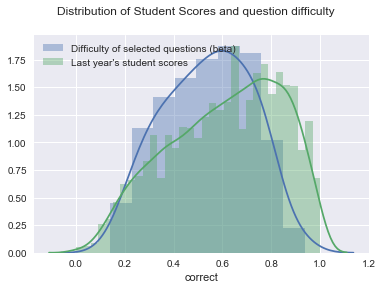

In [30]:
sns.distplot(final_df['beta'], label='Difficulty of selected questions (beta)')
sns.distplot(student_scores, label = 'Last year\'s student scores')
sns.plt.suptitle('Distribution of Student Scores and question difficulty')
legend = plt.legend()
plt.show()

Awesome...the questions match up well with how we antipate our students to be!

Just to finish, let's now go back and take out any questions for which alpha is greater than 0 or beta is outside of the 0-1 range.

In [31]:
absolute_final = final_df.query('beta>0& beta<1 &alpha<0')

In [32]:
param_df['alpha'].median()

-6.206977503574865

In [33]:
absolute_final['alpha'].median()

-7.051191462924223

So we now have appropriate difficulty, plus all of the other features we wanted (high differentiation and no beta outside [0,1]). Our test bank will contain {{len(absolute_final)}} questions.

### 5. Removed Questions<a name="rqs"></a>


To answer the original question, the questions to exclude are listed here in their entirety in the 'question index' column:

In [34]:
excluded = param_df.loc[~param_df['question index'].isin(absolute_final['question index'])]
excluded['question index'].reset_index()

,index,question index
0,2,26
1,3,27
2,4,28
3,6,44
4,7,45
5,9,54
6,11,57
7,13,59
8,15,64
9,17,66


This was my short solution. In total, this work alone probably took ~5 hours, plus a little more just tidy up my writing and try to eliminate typos for you. It is hard to judge, as there was more time spent thinking about the problem, and trying other solutions and other fun stuff, too. To get a sense of some other work that I put into the problem, please check out these links, as well.

- EDA ('eda.ipynb')
- Looking at inconsistent questions ('inconsistent_qs.ipynb')
- Clustering students in question space ('student_cluster.ipynb')

Thanks for your consideration, and I look foward to speaking soon about this work and more!